# Тематическая классификация длинных текстов — TFIDF и Perceptron

In [2]:
# Если ноутбук запускается на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt -qq
# import sys; sys.path.append('./stepik-dl-nlp')

In [14]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import classification_report

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

## Предобработка текстов и подготовка признаков

In [4]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка:', train_source['target'][0])
print('Имя класса:', train_source['target_names'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка: 7
Имя класса: alt.atheism


### Подготовка признаков

In [5]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


In [6]:
MAX_DF = 0.8
MIN_COUNT = 5
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 21628
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


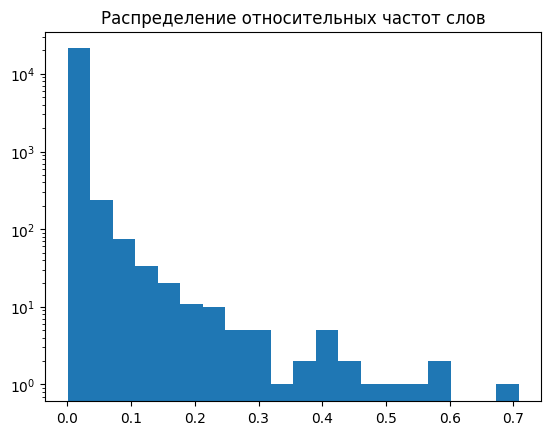

In [7]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [8]:
VECTORIZATION_MODE = 'tf' # tf, idf, tfidf
train_vectors = vectorize_texts(
    train_tokenized, vocabulary,
    word_doc_freq, mode=VECTORIZATION_MODE
)

test_vectors = vectorize_texts(
    test_tokenized, vocabulary,
    word_doc_freq, mode=VECTORIZATION_MODE
)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(
    train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1]))
     )
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(
    test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1]))
     )

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)

Количество ненулевых элементов в обучающей выборке 1126792
Процент заполненности матрицы признаков 0.46%

Количество ненулевых элементов в тестовой выборке 721529
Процент заполненности матрицы признаков 0.44%


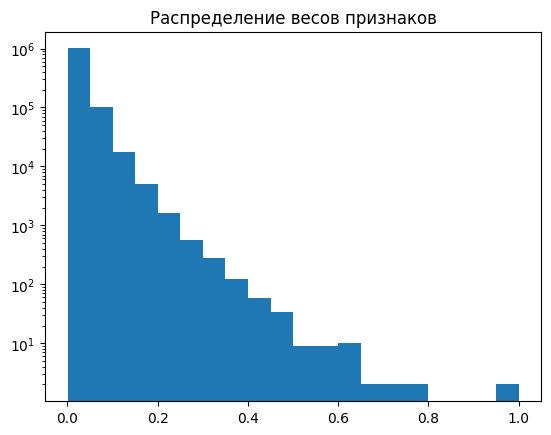

In [9]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

### Распределение классов

In [10]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


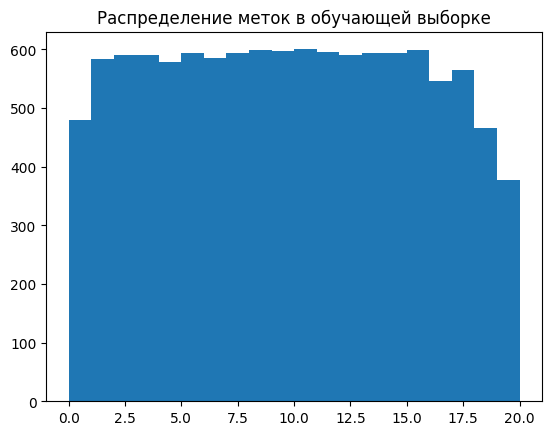

In [11]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

### PyTorch Dataset

In [12]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

## Обучение модели на PyTorch

In [13]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(
        optim, patience=5, factor=0.5, verbose=True
        )

best_val_loss, best_model = train_eval_loop(
    model=model,
    train_dataset=train_dataset,
    val_dataset=test_dataset,
    criterion=F.cross_entropy,
    lr=1e-1,
    epoch_n=200,
    batch_size=32,
    l2_reg_alpha=0,
    lr_scheduler_ctor=scheduler
)

Эпоха 0
Эпоха: 354 итераций, 2.86 сек
Среднее значение функции потерь на обучении 0.9939885928721751
Среднее значение функции потерь на валидации 0.8191646144299184
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 2.71 сек
Среднее значение функции потерь на обучении 0.12288620277692032
Среднее значение функции потерь на валидации 0.7228552392226154
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 2.67 сек
Среднее значение функции потерь на обучении 0.04704732515738677
Среднее значение функции потерь на валидации 0.6915893206151865
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 2.64 сек
Среднее значение функции потерь на обучении 0.027097857567760567
Среднее значение функции потерь на валидации 0.6741592844285197
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 2.64 сек
Среднее значение функции потерь на обучении 0.019526537603798643
Среднее значение функции потерь на валидации 0.6694322015648171
Новая лучшая модель!

Эпоха 5
Эпоха: 354 итераций, 2.61 сек
Среднее значение функ

## Оценка качества

In [16]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print(classification_report(
    train_source['target'],
    train_pred.argmax(-1),
    digits=4)
     )
print()

test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print(classification_report(
    test_source['target'],
    test_pred.argmax(-1),
    digits=4)
     )

100%|██████████| 354/353.5625 [00:01<00:00, 181.06it/s]


Среднее значение функции потерь на обучении 0.006103772670030594
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       480
           1     0.9983    0.9949    0.9966       584
           2     0.9966    0.9966    0.9966       591
           3     0.9966    1.0000    0.9983       590
           4     1.0000    1.0000    1.0000       578
           5     0.9983    1.0000    0.9992       593
           6     0.9983    0.9949    0.9966       585
           7     1.0000    0.9983    0.9992       594
           8     0.9983    1.0000    0.9992       598
           9     1.0000    1.0000    1.0000       597
          10     1.0000    1.0000    1.0000       600
          11     1.0000    1.0000    1.0000       595
          12     0.9966    0.9983    0.9975       591
          13     1.0000    1.0000    1.0000       594
          14     1.0000    1.0000    1.0000       593
          15     1.0000    1.0000    1.0000       599
          16    

236it [00:01, 185.11it/s]                             

Среднее значение функции потерь на валидации 0.6518105268478394
              precision    recall  f1-score   support

           0     0.7797    0.7210    0.7492       319
           1     0.6787    0.7275    0.7022       389
           2     0.7386    0.6599    0.6971       394
           3     0.6643    0.7015    0.6824       392
           4     0.7889    0.7766    0.7827       385
           5     0.8301    0.7544    0.7905       395
           6     0.8350    0.8436    0.8393       390
           7     0.8642    0.8359    0.8498       396
           8     0.8954    0.9246    0.9098       398
           9     0.9440    0.9345    0.9392       397
          10     0.9527    0.9599    0.9563       399
          11     0.8958    0.9116    0.9036       396
          12     0.7136    0.7735    0.7424       393
          13     0.8524    0.8460    0.8492       396
          14     0.8961    0.8756    0.8858       394
          15     0.8652    0.9196    0.8916       398
          16     

# Альтернативная реализация на scikit-learn

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [43]:
sklearn_pipeline = Pipeline((
    ('vect', TfidfVectorizer(
        tokenizer=tokenize_text_simple_regex,
        max_df=MAX_DF,
        min_df=MIN_COUNT)),
    ('cls', LogisticRegression(
        verbose=1,
        ))
    ))

sklearn_pipeline.fit(train_source['data'], train_source['target']);

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       432580     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.38937D+04    |proj g|=  1.88700D+02


 This problem is unconstrained.



At iterate   50    f=  1.38898D+04    |proj g|=  1.88819D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****     94    104      1     0     0   5.266D-02   1.389D+04
  F =   13888.789849714241     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


## Оценка качества

In [44]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(
    torch.from_numpy(sklearn_train_pred),
    torch.from_numpy(train_source['target'])
)
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print(classification_report(
    train_source['target'],
    sklearn_train_pred.argmax(-1),
    digits=4
))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(
    torch.from_numpy(sklearn_test_pred),
    torch.from_numpy(test_source['target'])
)
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print(classification_report(
    test_source['target'],
    sklearn_test_pred.argmax(-1),
    digits=4
))

Среднее значение функции потерь на обучении 2.4954788918584985
              precision    recall  f1-score   support

           0     0.9769    0.9688    0.9728       480
           1     0.9286    0.9572    0.9427       584
           2     0.9481    0.9577    0.9529       591
           3     0.9269    0.9237    0.9253       590
           4     0.9720    0.9602    0.9661       578
           5     0.9795    0.9663    0.9728       593
           6     0.9201    0.9641    0.9416       585
           7     0.9846    0.9680    0.9762       594
           8     0.9966    0.9816    0.9890       598
           9     0.9933    0.9950    0.9941       597
          10     0.9950    0.9917    0.9933       600
          11     0.9966    0.9832    0.9898       595
          12     0.9468    0.9645    0.9556       591
          13     0.9966    0.9798    0.9881       594
          14     0.9783    0.9882    0.9832       593
          15     0.9596    0.9917    0.9754       599
          16     0